In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

%env JOBLIB_TEMP_FOLDER=/tmp

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import seaborn as sns
sns.set_style('whitegrid')

from PIL import Image
from imageio import imread
import imageio
import skimage
import skimage.io
import skimage.transform
from imageio import imread


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

from skimage.morphology import closing, disk, opening
import random
import time
import copy
from tqdm import tqdm_notebook as tqdm
from os import listdir
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import model_from_json
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

from os import listdir
from skimage.segmentation import mark_boundaries

import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

env: JOBLIB_TEMP_FOLDER=/tmp


Using TensorFlow backend.


/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/173.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/491.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/379.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/248.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/94.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/480.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/236.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/340.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/48.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/513.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/350.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/314.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/227.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/238.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/61.pn

In [2]:
Directory='../input/v2-plant-seedlings-dataset/nonsegmentedv2/'
subfolders = listdir(Directory)
print(os.listdir('../input/v2-plant-seedlings-dataset/nonsegmentedv2/'))

['Scentless Mayweed', 'Common wheat', 'Charlock', 'Black-grass', 'Sugar beet', 'Loose Silky-bent', 'Maize', 'Cleavers', 'Common Chickweed', 'Fat Hen', 'Small-flowered Cranesbill', 'Shepherd’s Purse']


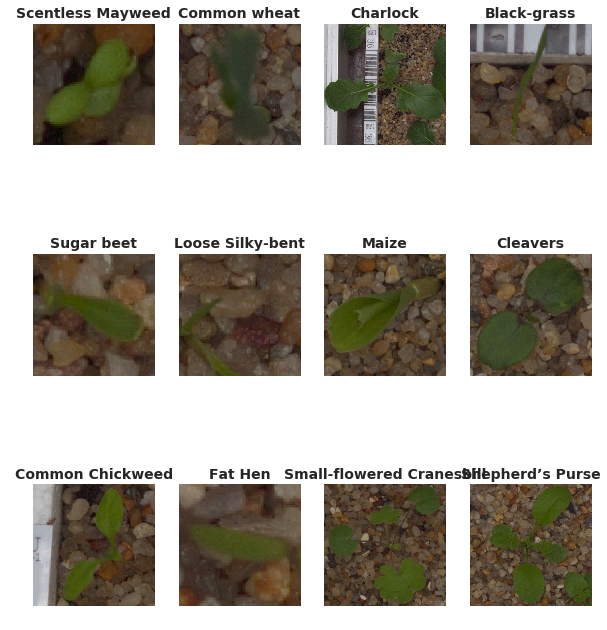

In [3]:
sfc="Small-flowered Cranesbill"
plt.figure(figsize=(10,12))

for n in range(12):
        folder=subfolders[n]
        plt.subplot(3,4,n+1)
        files = listdir(Directory + folder + "/") 
        image=cv2.imread(Directory + folder + "/" + files[n+221])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(folder, fontsize=14, weight='bold')

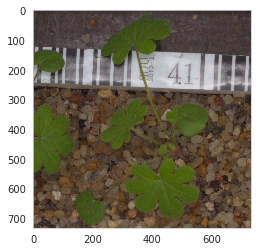

In [4]:
p1 = cv2.imread('/kaggle/input/v2-plant-seedlings-dataset/nonsegmentedv2/Small-flowered Cranesbill/135.png')
p1 = cv2.cvtColor(p1, cv2.COLOR_BGR2RGB)
plt.imshow(p1)
plt.grid(False)
plt.show()

We will try to process this image in order to get rid of the unnecessary pixels. Feeding this picture to the model directly will result in a target leakage. The classifier will learn the stones and the container's pixels and build its prediction upon these pixels as well. This is something we would like to avoid.

We start our preprocessing with simply segment an object from an image based on color using OpenCV. A popular computer vision library written in C/C++ with bindings for Python, [OpenCV provides easy ways of manipulating color spaces [2].](https://realpython.com/python-opencv-color-spaces/)

In [5]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
pixel_colors = p1.reshape((np.shape(p1)[0]*np.shape(p1)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

> ### 2.2 Visualize the plant image in RGB color space:

Here, we visualize the small-flowered Cranesbill image we opened above in RGB space to see the distributions of the color pixels.

RGB is considered an “additive” color space, and colors can be imagined as being produced from shining quantities of red, blue, and green light onto a black background.

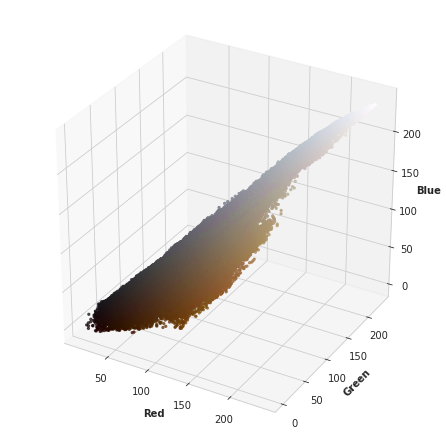

In [6]:
r, g, b = cv2.split(p1)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
set_size(6,6)
pixel_colors = p1.reshape((np.shape(p1)[0]*np.shape(p1)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red", weight='bold')
axis.set_ylabel("Green", weight='bold')
axis.set_zlabel("Blue", weight='bold')

plt.show()

From this plot, you can see that the green parts of the image are mixed with the red and blue values.  Segmenting our plant image out in RGB space based on ranges of RGB values would not be easy. 

The solution is to try another color space, we go next with HSV color space.

> ### 2.3 Visualize the plant image in HSV color space:

**HSV** stands for **Hue, Saturation, and Value (or brightness)**, and is a cylindrical color space. The colors, or hues, are modeled as an angular dimension rotating around a central, vertical axis, which represents the value channel. Values go from dark (0 at the bottom) to light at the top. The third axis, saturation, defines the shades of hue from least saturated, at the vertical axis, to most saturated furthest away from the center:

In [7]:
hsv_p1 = cv2.cvtColor(p1, cv2.COLOR_RGB2HSV)

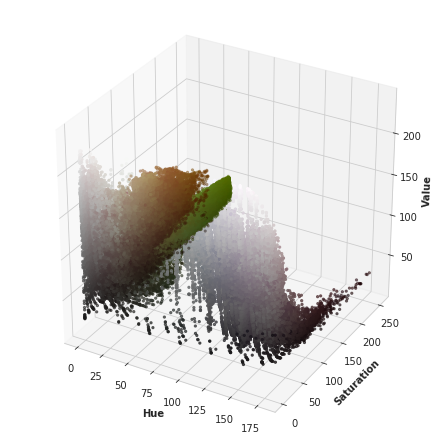

In [8]:
h, s, v = cv2.split(hsv_p1)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")


axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue",weight='bold')
axis.set_ylabel("Saturation", weight='bold')
axis.set_zlabel("Value", weight='bold')
set_size(6,6)
plt.show()

In HSV space, our plant’s greens are much more localized and visually separable. The saturation and value of the greens do vary, but they are mostly located within a small range along the hue axis. This is the key point that can be leveraged for segmentation.

# 3- Segmentation:
***
> ### 3.1 Color-based segmentation:

To pick out a range color, we can use a [color picking app online [3]](https://toolstud.io/color/rgb.php). I found the green color ranges in a [forum](https://stackoverflow.com/questions/47483951/how-to-define-a-threshold-value-to-detect-only-green-colour-objects-in-an-image): 
* **minimum green**(H=**36**, S=**25**, V=**25**)
* **maximum green**(H=**70**, S=**255**,V=**255**)

We will use the openCV function *cv2.inRange()* to try to threshold our plant image with the minimum and maximum green values. 

*inRange()* takes three parameters: the image, the lower range, and the higher range. It returns a binary mask (an ndarray of 1s and 0s) the size of the image where values of 1 indicate values within the range, and zero values indicate values outside [2].

In [9]:
def plot_mask(image, colormin, colormax):
        hsv_p1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)   
        mask = cv2.inRange(hsv_p1, colormin , colormax)
        result = cv2.bitwise_and(image, image, mask=mask)
        plt.figure(figsize=(15,10))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.grid(False)
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap="gray")
        plt.grid(False)
        plt.subplot(1, 3, 3)
        plt.imshow(result)
        plt.grid(False)
        return plt.show()

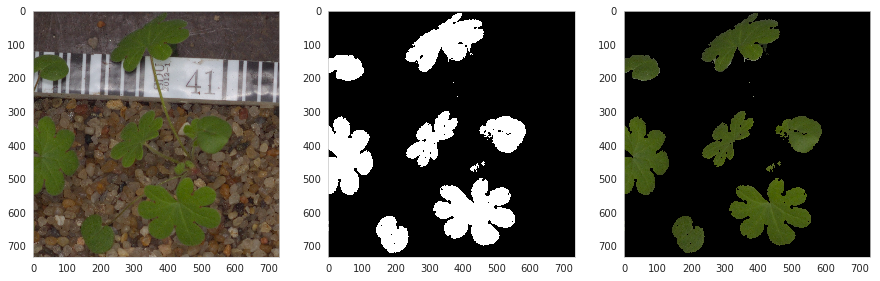

In [10]:
colormin=(36, 25, 25)
colormax=(70, 255,255)

plot_mask(p1, colormin, colormax)

The result of our initial threshold is not bad, but we are missing some pixels of the plants. We will try to play manually with the saturation and brightness values to get a better a mask.

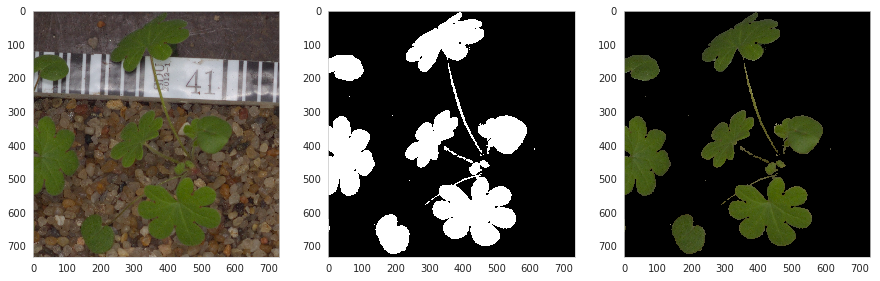

In [11]:
new_colormin=(25,50,50)
new_colormax=(80,255,255)
plot_mask(p1, new_colormin, new_colormax)

**Great!** The segmentation looks fine. We got rid of the stones and the containers pixels. Let's apply this mask on the rest of pictures and visualize the results.

> ### 3.2 Segmentation function:

Now, we create a function that applies segmentation on the rest of the images. This function will be used to feed the computer vision model with the segmented images instead of the original ones.

In [12]:
def segmented(image):
    foto = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv_foto = cv2.cvtColor(foto, cv2.COLOR_RGB2HSV)
    #print("hsvh",hsv_foto.dtype)
    colormin=(25,50,50)
    colormax=(86,255,255)

    mask = cv2.inRange(hsv_foto, colormin , colormax)
    #print("mask",mask.dtype)
    result = cv2.bitwise_and(foto, foto, mask=mask)
    #print("result",result.dtype)
    pil_image= Image.fromarray(result)


    return result

> ### 3.3 Visualize the results of segmentation on the 12 plant species

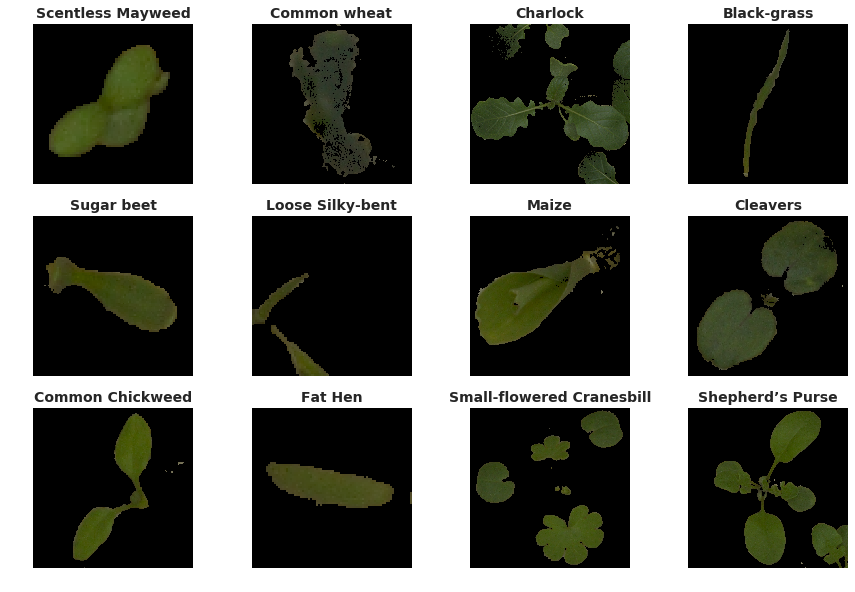

In [13]:
plt.figure(figsize=(15,10))

for n in range(12):
        folder = subfolders[n]
        plt.subplot(3,4,n+1)
        files = listdir(Directory + folder + "/") 
        image=cv2.imread(Directory + folder + "/" + files[n+221])
        plt.imshow(segmented(image))
        plt.axis("off")
        plt.title(folder, weight='bold', fontsize=14)


In [14]:
def segmented2(image):
    image=np.array(image)
    #foto=image.copy().astype(np.uint8)
    #foto = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv_foto = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    colormin=(25,50,50)
    colormax=(90,255,255)
    mask = cv2.inRange(hsv_foto, colormin , colormax)
    
    #result = cv2.bitwise_and(foto, foto, mask=mask)
    result = cv2.bitwise_and(image, image, mask=mask)
    result2=np.array(result)
    #pil_image= Image.fromarray(result, mode='RGB')
    #pil_image= Image.fromarray(result)


    return result2

# 4- Computer vision model:
***

In this section, we will try to feed those plant images to a pretrained VGG16 convolutional neural network. We will train with both original and segmented images in order to find out the impact of the target leakage on training.
> ### 4.1 VGG16 with original plant images:

In [15]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2,
        #preprocessing_function = segmented2
                     )


train_generator = train_datagen.flow_from_directory(
    '../input/v2-plant-seedlings-dataset/nonsegmentedv2',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        '../input/v2-plant-seedlings-dataset/nonsegmentedv2',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 4437 images belonging to 12 classes.
Found 1102 images belonging to 12 classes.


In [16]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, Flatten

vgg_conv = VGG16(weights=None, include_top=False, input_shape=(64, 64, 3))
vgg_conv.load_weights('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

model = Sequential()
model.add(vgg_conv)
 
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                12300     
Total params: 16,825,164
Trainable params: 9,189,900
Non-trainable params: 7,635,264
_________________________________________________________________


In [17]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
# We'll stop training if no improvement after some epochs
earlystopper1 = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Save the best model during the traning
checkpointer1 = ModelCheckpoint('best_model1.hdf5'
                                ,monitor='val_accuracy'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)

In [19]:
history = model.fit_generator(train_generator, steps_per_epoch=50, 
                    validation_data=validation_generator,
                    validation_steps=128,
                    epochs=15, verbose=1,
                   callbacks=[checkpointer1])

Epoch 1/15
50/50 [==============================] - 70s 1s/step - loss: 2.2234 - accuracy: 0.2325 - val_loss: 2.0629 - val_accuracy: 0.3585

Epoch 00001: val_accuracy improved from -inf to 0.35849, saving model to best_model1.hdf5
Epoch 2/15
50/50 [==============================] - 57s 1s/step - loss: 1.6476 - accuracy: 0.4281 - val_loss: 1.9561 - val_accuracy: 0.4610

Epoch 00002: val_accuracy improved from 0.35849 to 0.46098, saving model to best_model1.hdf5
Epoch 3/15
50/50 [==============================] - 54s 1s/step - loss: 1.3229 - accuracy: 0.5173 - val_loss: 1.2412 - val_accuracy: 0.5131

Epoch 00003: val_accuracy improved from 0.46098 to 0.51311, saving model to best_model1.hdf5
Epoch 4/15
50/50 [==============================] - 47s 950ms/step - loss: 1.1540 - accuracy: 0.6012 - val_loss: 1.2580 - val_accuracy: 0.5842

Epoch 00004: val_accuracy improved from 0.51311 to 0.58424, saving model to best_model1.hdf5
Epoch 5/15
50/50 [==============================] - 45s 900ms/st

> ### 4.2 Model evaluation:

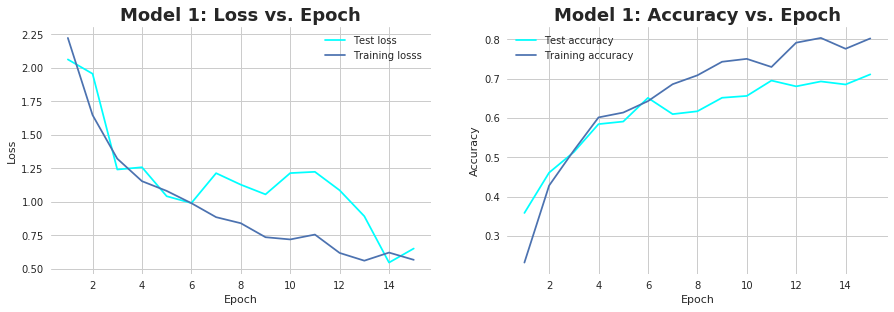

In [20]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,10))
#First Model
ax1 = plt.subplot2grid((2,2),(0,0))
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'cyan', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training losss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1: Loss vs. Epoch',weight='bold', fontsize=18)
ax1 = plt.subplot2grid((2,2),(0,1))
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'cyan', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1: Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()